# Homework 4

As always, please provide your solution in a Jupyter Notebook.

1. Now that you have all the tools to train an MLP with high performance on MNIST, try reaching 0-loss (or 100% accuracy) on the training data (with a small epsilon, e.g. 99.99% training performance -- don't worry if you overfit!). The implementation is completely up to you. You just need to keep it an MLP without using fancy layers (e.g., keep the `Linear` layers, don't use `Conv1d` or something like this, don't use attention). You are free to use any LR scheduler or optimizer, any one of batchnorm/groupnorm, regularization methods... If you use something we haven't seen during lectures, please motivate your choice and explain (as briefly as possible) how it works.

2. Try reaching 0-loss on the training data with **permuted labels**. Assess the model on the test data (without permuted labels) and comment. Help yourself with [3](https://arxiv.org/abs/1611.03530). *Tip:* To permute the labels, act on the `trainset.targets` with an appropriate torch function. Then, you can pass this "permuted" `Dataset` to a `DataLoader` like so:
`trainloader_permuted = torch.utils.data.DataLoader(trainset_permuted, batch_size=batch_size_train, shuffle=True)`.
You can now use this `DataLoader` inside the training function. Additional view for motivating this exercise: ["The statistical significance perfect linear separation", by Jared Tanner (Oxford U.)](https://www.youtube.com/watch?v=vl2QsVWEqdA).

[3](https://arxiv.org/abs/1611.03530) Zhang, C., Bengio, S., Hardt, M., Recht, B., & Vinyals, O. (2016). Understanding deep learning requires rethinking generalization.

P.S. I increased the number of files to upload from 1 to 5, so if you want you may include up to 4 local image files in your solution.

In [2]:
import os
import sys
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
import copy


sys.path.append("../labs")

from scripts import mnist
from scripts.train_utils import accuracy, AverageMeter

In [4]:
def train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, performance_meter, performance, device):
    for X, y in dataloader:
        # TRANSFER X AND y TO GPU IF SPECIFIED
        X = X.to(device)
        y = y.to(device)
        # 1. reset the gradients previously accumulated by the optimizer
        #    this will avoid re-using gradients from previous loops
        optimizer.zero_grad() 
        # 2. get the predictions from the current state of the model
        #    this is the forward pass
        y_hat = model(X)
        # 3. calculate the loss on the current mini-batch
        loss = loss_fn(y_hat, y)
        # 4. execute the backward pass given the current loss
        loss.backward()
        # 5. update the value of the params
        optimizer.step()
        # 6. calculate the accuracy for this mini-batch
        acc = performance(y_hat, y)
        # 7. update the loss and accuracy AverageMeter
        loss_meter.update(val=loss.item(), n=X.shape[0])
        performance_meter.update(val=acc, n=X.shape[0])


def train_model(model, dataloader, loss_fn, optimizer, num_epochs, checkpoint_loc=None, checkpoint_name="checkpoint.pt", performance=accuracy, device=None):

    # establish device
    if device is None:
        device = "cuda:0" if torch.cuda.is_available() else "cpu"
    print(f"Training on {device}")

    # create the folder for the checkpoints (if it's not None)
    if checkpoint_loc is not None:
        os.makedirs(checkpoint_loc, exist_ok=True)
    
    model.to(device)
    model.train()

    # epoch loop
    for epoch in range(num_epochs):
        # modify the hyperparameters of our optimizer mid-training
        if epoch in (9, 19, 29):
            for pg in optimizer.param_groups:
                pg["lr"] *= .1
        loss_meter = AverageMeter()
        performance_meter = AverageMeter()

        train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, performance_meter, performance, device)

        print(f"Epoch {epoch+1} completed. Loss - total: {loss_meter.sum} - average: {loss_meter.avg}; Performance: {performance_meter.avg}")

        # produce checkpoint dictionary -- but only if the name and folder of the checkpoint are not None
        if checkpoint_name is not None and checkpoint_loc is not None:
            checkpoint_dict = {
                "parameters": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch
            }
            torch.save(checkpoint_dict, os.path.join(checkpoint_loc, checkpoint_name))

    return loss_meter.sum, performance_meter.avg

def test_model(model, dataloader, performance=accuracy, loss_fn=None, device=None):

    # establish device
    if device is None:
        device = "cuda:0" if torch.cuda.is_available() else "cpu"
    print(f"Testing on {device}")
    
    # create an AverageMeter for the loss if passed
    if loss_fn is not None:
        loss_meter = AverageMeter()
    
    performance_meter = AverageMeter()

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
            loss = loss_fn(y_hat, y) if loss_fn is not None else None
            acc = performance(y_hat, y)
            if loss_fn is not None:
                loss_meter.update(loss.item(), X.shape[0])
            performance_meter.update(acc, X.shape[0])
    # get final performances
    fin_loss = loss_meter.sum if loss_fn is not None else None
    fin_perf = performance_meter.avg
    print(f"TESTING - loss {fin_loss if fin_loss is not None else '--'} - performance {fin_perf}")
    return fin_loss, fin_perf

## Point 1

In [5]:
minibatch_size_train = 256
minibatch_size_test = 512

trainloader, testloader, trainset, testset = mnist.get_data(data_root="../labs/datasets/", batch_size_train=minibatch_size_test, batch_size_test=minibatch_size_test)

In [2]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.flat = torch.nn.Flatten()
        self.layer1 = torch.nn.Linear(28*28, 512)
        self.layer2 = torch.nn.Linear(512, 32)
        self.layer3 = torch.nn.Linear(32, 10)

    def forward(self, X): 
        out = self.flat(X)
        out = self.layer1(out)
        out = torch.nn.functional.relu(out)
        out = self.layer2(out)
        out = torch.nn.functional.relu(out)
        out = self.layer3(out)
        out = torch.nn.functional.log_softmax(out)
        return out

Let's use the vanilla SGD with momentum:

In [5]:
num_epochs = 30
lr = 0.01

model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_fn = torch.nn.CrossEntropyLoss()

Let's train our network:

In [6]:
train_model(model, trainloader, loss_fn, optimizer, num_epochs, device="cpu")

Training on cpu


/home/angela/Documenti/Deep Learning/DSSC_DL_2021/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
/home/angela/Documenti/Deep Learning/DSSC_DL_2021/venv/lib/python3.6/site-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


Epoch 1 completed. Loss - total: 21557.1648144722 - average: 0.3592860802412033; Performance: 0.8872
Epoch 2 completed. Loss - total: 6554.022935390472 - average: 0.10923371558984121; Performance: 0.9670166666666666
Epoch 3 completed. Loss - total: 5037.587438344955 - average: 0.08395979063908258; Performance: 0.9737833333333333
Epoch 4 completed. Loss - total: 3570.4207960367203 - average: 0.05950701326727867; Performance: 0.9816833333333334
Epoch 5 completed. Loss - total: 3343.7776812314987 - average: 0.05572962802052498; Performance: 0.9824666666666667
Epoch 6 completed. Loss - total: 3149.705152928829 - average: 0.05249508588214715; Performance: 0.9827
Epoch 7 completed. Loss - total: 2531.7850933670998 - average: 0.042196418222785; Performance: 0.98625
Epoch 8 completed. Loss - total: 2497.6445816755295 - average: 0.04162740969459216; Performance: 0.98685
Epoch 9 completed. Loss - total: 2213.0989110320807 - average: 0.036884981850534675; Performance: 0.9879833333333333
Epoch 10 

(58.02163189742714, 0.9999166666666667)

And now let's test it:

In [7]:
test_model(model, testloader, performance=accuracy, loss_fn=loss_fn, device="cpu")

Testing on cpu


/home/angela/Documenti/Deep Learning/DSSC_DL_2021/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


TESTING - loss 57.83349530771375 - performance 0.9999166666666667


(57.83349530771375, 0.9999166666666667)

So we managed to reach a preformance of $99.99\%$ and an average loss of $~0.000967$.

## Point 2

In [7]:
def worker_init_function(proc_id):
    process_seed = torch.initial_seed()
    # Back out the base_seed so we can use all the bits.
    base_seed = process_seed - proc_id
    ss = np.random.SeedSequence([proc_id, base_seed])
    # More than 128 bits (4 32-bit words) would be overkill.
    np.random.seed(ss.generate_state(4))

In [8]:
perm = torch.randperm(len(trainset.targets))
trainset_permuted = copy.deepcopy(trainset)
trainset_permuted.targets = trainset.targets[perm]
trainloader_permuted = torch.utils.data.DataLoader(trainset_permuted, batch_size=minibatch_size_train, shuffle=True, num_workers=4, worker_init_fn=worker_init_function)

In [9]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.flat = torch.nn.Flatten()
        self.layer1 = torch.nn.Linear(28*28, 1024)
        self.layer2 = torch.nn.Linear(1024, 512)
        self.layer3 = torch.nn.Linear(512, 10)

    def forward(self, X): 
        out = self.flat(X)
        out = self.layer1(out)
        out = torch.nn.functional.leaky_relu(out)
        out = self.layer2(out)
        out = torch.nn.functional.leaky_relu(out)
        out = self.layer3(out)
        out = torch.nn.functional.log_softmax(out)
        return out

In [12]:
num_epochs = 30
lr = 0.001

model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_fn = torch.nn.CrossEntropyLoss()

In [13]:
train_model(model, trainloader_permuted, loss_fn, optimizer, num_epochs, device="cpu")

Training on cpu


/home/angela/Documenti/Deep Learning/DSSC_DL_2021/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
/home/angela/Documenti/Deep Learning/DSSC_DL_2021/venv/lib/python3.6/site-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


Epoch 1 completed. Loss - total: 138250.0248184204 - average: 2.304167080307007; Performance: 0.10598333333333333
Epoch 2 completed. Loss - total: 138130.28281402588 - average: 2.3021713802337644; Performance: 0.11103333333333333
Epoch 3 completed. Loss - total: 138090.6477279663 - average: 2.301510795466105; Performance: 0.11113333333333333
Epoch 4 completed. Loss - total: 138029.12187194824 - average: 2.3004853645324705; Performance: 0.11375
Epoch 5 completed. Loss - total: 137932.97441101074 - average: 2.298882906850179; Performance: 0.1162
Epoch 6 completed. Loss - total: 137807.49898529053 - average: 2.296791649754842; Performance: 0.1173
Epoch 7 completed. Loss - total: 137628.49787902832 - average: 2.2938082979838055; Performance: 0.1211
Epoch 8 completed. Loss - total: 137274.79403686523 - average: 2.2879132339477537; Performance: 0.12405
Epoch 9 completed. Loss - total: 136771.8848953247 - average: 2.2795314149220784; Performance: 0.13353333333333334
Epoch 10 completed. Loss -

(124708.69303894043, 0.24935)

In [14]:
test_model(model, testloader, performance=accuracy, loss_fn=loss_fn, device="cpu")

Testing on cpu


/home/angela/Documenti/Deep Learning/DSSC_DL_2021/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


TESTING - loss 145964.36348724365 - performance 0.11561666666666667


(145964.36348724365, 0.11561666666666667)

The fact that the performance is $10\%$ makes me think that the model is always predicting the same class, thus being right $1/10$ of the times (since we have $10$ classes).

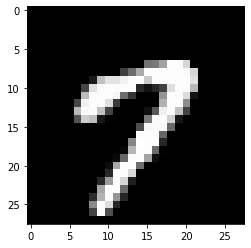

In [18]:
plt.imshow(trainset.data[15].numpy(), cmap="gray")

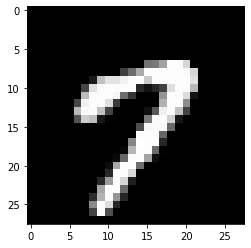

In [26]:
plt.imshow(trainset_permuted.data[15].numpy(), cmap="gray")

In [34]:
for i, (X, y) in enumerate(trainloader_permuted):
    if i == 15:
        y_hat = model(X)
        print(y_hat.shape, y.shape)
        
print(i)

/home/angela/Documenti/Deep Learning/DSSC_DL_2021/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


torch.Size([256, 10]) torch.Size([256])
234
